<img src="./images/header.png">

***

# Projeto 4 - Experimento Autoencoder

Discente: Willian Vieira de Oliveira

Doscente: Dr. Marcos Quiles

## Descrição do projeto

Implementar um **autoencoder** (usar Keras - ou não...), considerando o dataset MNIST.
    - Variar o número de neurônios internos e o número de camadas (stacks);
    - Visualizar a codificação gerada pelos neurônios da primeira camada oculta;
    - Implementar um autoencoder com uma camada de codificação linear;
    - Comparar o resultado com a PCA.

***

## Pacotes utilizados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline 

import seaborn as sns
from math import sqrt

# Autoencoder development
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.python.keras import utils
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings("ignore")

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Dataset MNIST

#### Descrição do dataset

- **Título:** MNIST dataset - Modified National Institute of Standards and Technology dataset;
- **Criadores:** Yann LeCun, Corinna Cortes e Christopher J.C. Burges;
- **Data:** 2010;

- **Descrição dos dados** Imagens de números escritos a mão;
- **Conjunto de treino** 60000 examplos;
- **Conjunto de teste:** 10000 examplos;
   
- **Mais informações:** http://yann.lecun.com/exdb/mnist/.

In [2]:
from keras.datasets import mnist

Using TensorFlow backend.


#### Dados de entrada

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

#### Vizualização do primeiro dígido do conjunto de treino

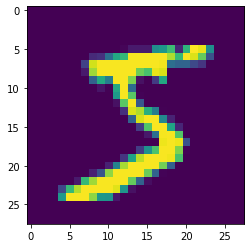

Digito:  5


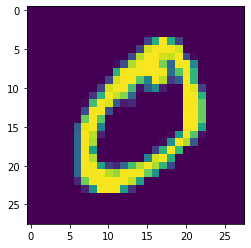

Digito:  0


In [4]:
plt.imshow(X_train[0])
plt.show()
print("Digito: ", Y_train[0])


plt.imshow(X_train[1])
plt.show()
print("Digito: ", Y_train[1])

### Data preparation

In [5]:
X_train[0].shape

(28, 28)

In [6]:
# Scale the dataset values to lie between 0 and 1
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Data reshaping
#X_train_ = np.reshape(X_train, (len(X_train), X_train[0].shape[0], X_train[0].shape[1], 1))
#X_test_ = np.reshape(X_test, (len(X_test), X_test[0].shape[0], X_test[0].shape[1], 1))

X_train_ = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test_ = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(X_train_.shape)
print(X_test_.shape)

(60000, 784)
(10000, 784)


In [7]:
input_shape = X_train_[1].shape[0]
input_shape

784

## Funções auxiliar para criação do autoencoder

Para geração do autoencoder foi utilizado a função de ativação 'Rectified Linear Unit' (relu) para todas as camadas intermidiárias. Para a camada de saída foi adotado a função de ativação 'sigmoid'. O número de camadas escondidas e neurônios variou conforme o teste realizado.

In [8]:
# https://blog.keras.io/building-autoencoders-in-keras.html
def Autoencoder_model(Neurons_in_encoder_layers, Neurons_in_decoder_layers, input_shape):
    
    input_img = Input(shape=(input_shape,))
    
    # First hidden layer
    encoded = Dense(units=Neurons_in_encoder_layers[0], activation="relu")(input_img)  
    
    # Intermediate hidden layers
    # Encoder
    for n_neurons in Neurons_in_encoder_layers[1:]:
        encoded = Dense(units=n_neurons, activation='relu')(encoded)
    # Decoder
    decoded = encoded
    for n_neurons in Neurons_in_decoder_layers:
        decoded = Dense(units=n_neurons, activation='relu')(decoded)
    
    # output layer, considering the same dimension of the input data
    decoded = Dense(units=input_shape, activation='sigmoid')(decoded)
    
    # Models
    # - this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)
    
    # - this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)
    
    # - decoder model
    compression_factor = input_shape/Neurons_in_encoder_layers[0] # The number of neurons in the output layer must be equal to 
                                                                        #the number o neurons in the output layer
    encoding_dim = input_shape/compression_factor
    encoded_input = Input(shape=(encoding_dim,)) # create a placeholder for an encoded (32-dimensional) input
    decoder_layer = autoencoder.layers[-1] # retrieve the last layer of the autoencoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input)) # create the decoder model
    
    print("Compression factor used to define the decoder model: ", compression_factor)
    
    return autoencoder, encoder, decoder

***

## Testes realizados

Os testes realizados nesse projeto consideraram a variação dos parâmetros associados ao número de neurônios internos e o número de stacks.

### Teste 1
- **Camadas escondidas:** 3
- **Neurônios internos:** {32, 16, 32}

In [9]:
Neurons_in_encoder_layers = [32, 16]
Neurons_in_decoder_layers = [32]

In [10]:
autoencoder, encoder, decoder = Autoencoder_model(Neurons_in_encoder_layers, Neurons_in_decoder_layers, input_shape)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.
Compression factor used to define the decoder model:  24.5


In [11]:
history = autoencoder.fit(X_train_, X_train_, epochs=100, batch_size=256, shuffle=True, validation_data=(X_test_, X_test_),
                          verbose=False)

Instructions for updating:
Use tf.cast instead.


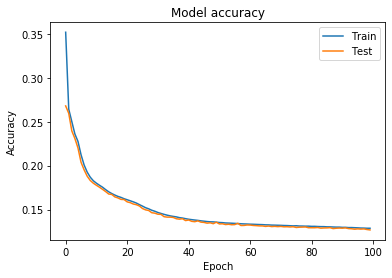

In [12]:
# plot history
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [13]:
# Encode and decode some digits
encoded_imgs = encoder.predict(X_test_)
decoded_imgs = autoencoder.predict(X_test_)

In [14]:
# Get codification generated by the first hidden layer
layer_outputs = [layer.output for layer in autoencoder.layers[:102] if not layer.name.startswith('input')]
first_HL = Model(inputs=autoencoder.input, outputs=layer_outputs[0])

encoded_images_First_HL = first_HL.predict(X_test_)

#### Visualização das entradas reconstruídas e das representações codificadas pela primeira camada oculta

In [15]:
# How many digits we will display
n = 10  
print("Número de dígitos a ser visualizado: ", n)

Número de dígitos a ser visualizado:  10


Dígitos originais: 


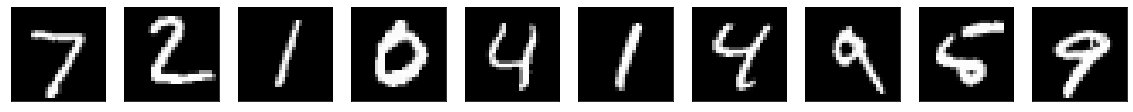

Dígitos codificados pela primeira camada oculta: 


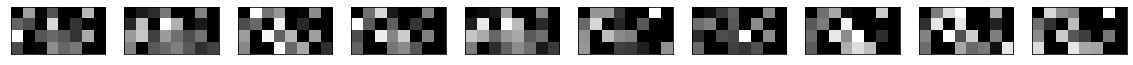

Dígitos reconstruídos: 


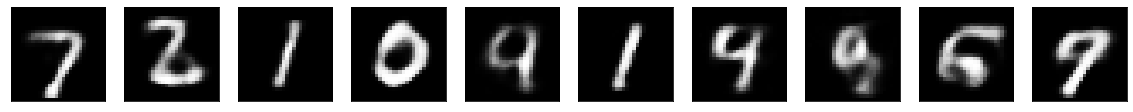

In [16]:
print("Dígitos originais: ")
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Dígitos codificados pela primeira camada oculta: ")
plt.figure(figsize=(20, 10))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_images_First_HL[i].reshape(8, 4).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Dígitos reconstruídos: ")
plt.figure(figsize=(20, 4))
for i in range(n):
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

***

### Teste 2
- **Camdas escondidas:** 5
- **Neurônios internos:** {128, 64, 32, 64, 128}


In [17]:
Neurons_in_encoder_layers = [128, 64, 32]
Neurons_in_decoder_layers = [64, 128]

In [18]:
autoencoder, encoder, decoder = Autoencoder_model(Neurons_in_encoder_layers, Neurons_in_decoder_layers, input_shape)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Compression factor used to define the decoder model:  6.125


In [19]:
history = autoencoder.fit(X_train_, X_train_, epochs=100, batch_size=256, shuffle=True, validation_data=(X_test_, X_test_),
                          verbose=False)

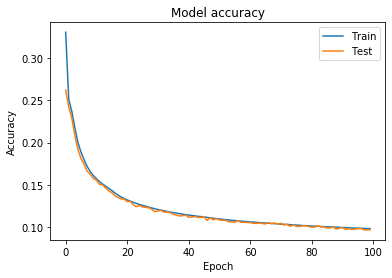

In [20]:
# plot history
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [21]:
# Encode and decode some digits
encoded_imgs = encoder.predict(X_test_)
decoded_imgs = autoencoder.predict(X_test_)

In [22]:
# Get codification generated by the first hidden layer
layer_outputs = [layer.output for layer in autoencoder.layers[:102] if not layer.name.startswith('input')]
first_HL = Model(inputs=autoencoder.input, outputs=layer_outputs[0])

encoded_images_First_HL = first_HL.predict(X_test_)

#### Visualização das entradas reconstruídas e das representações codificadas pela primeira camada oculta

In [23]:
# How many digits we will display
n = 10  
print("Número de dígitos a ser visualizado: ", n)

Número de dígitos a ser visualizado:  10


Dígitos originais: 


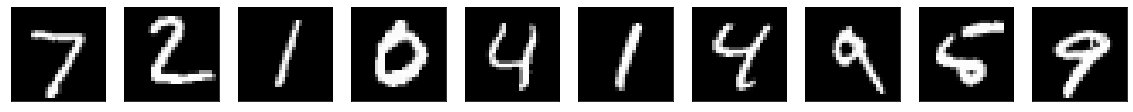

Dígitos codificados pela primeira camada oculta: 


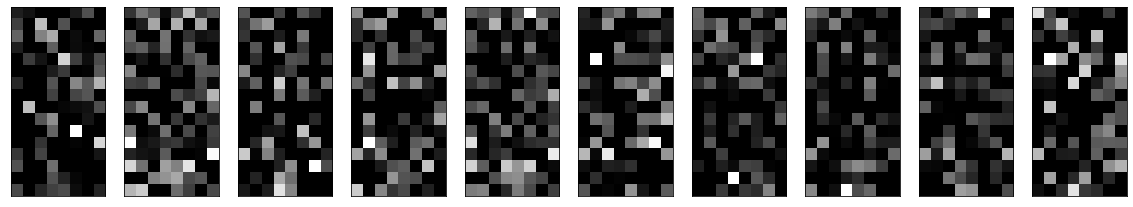

Dígitos reconstruídos: 


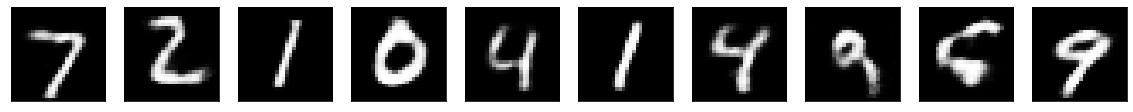

In [24]:
print("Dígitos originais: ")
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Dígitos codificados pela primeira camada oculta: ")
plt.figure(figsize=(20, 10))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_images_First_HL[i].reshape(8, 16).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Dígitos reconstruídos: ")
plt.figure(figsize=(20, 4))
for i in range(n):
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Em geral, autoencoders visam aprender uma representação (encoding) para um determinado conjunto de dados, tipicamente para o propósito de redução de dimensionalidade. A partir dos dois testes realizados é possível observar a influência da estrutura definida para o Autoencoder na representação de um conjunto de dados. No segundo teste foi considerado um maior número de camadas ocultas, além de um maior número de neurônios em cada camada. Este teste resultou em uma melhor representação dos dígitos analisados.

### Comparação com PCA

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_)
X_scaled = scaler.transform(X_train_)

In [32]:
scaler = StandardScaler()
scaler.fit(X_train_)
X_sc_train = scaler.transform(X_train_)
X_sc_test = scaler.transform(X_test_)

#### PCA decomposition

O número de componentes adotada abaixo foi definido arbitrariamente para visualização da variância acumulativa desse conjunto de dados. A partir do gráfico ilustrado abaixo foi definido o número de componentes a ser adotado para transformação do conjunto de dados analisado nesse notebook.

Text(0, 0.5, 'Cumulative explained variance')

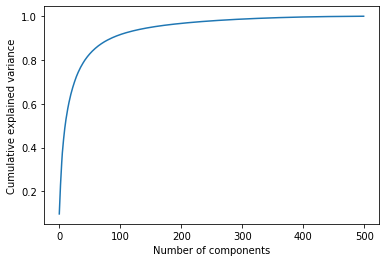

In [33]:
pca = PCA(n_components=500)
pca.fit(X_train_)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

A partir da análise do gráfico acima foi definido um número de componentes igual a 100. No gráfico é possível observar que a variância acumulativa é alta próximo de 100 componentes, crescendo lentamente após este número de componentes. Assim, acredita-se que os daddos que descrevem as alterações estão contidos principalmente em 100 componentes. Para fins de comparação, este teste foi repetido utilizando-se também um número de componentes igual a 200

#### Número de componentes: 100

In [51]:
NCOMPONENTS = 100

pca = PCA(n_components=NCOMPONENTS)
X_pca_train = pca.fit_transform(X_sc_train)
X_pca_test = pca.transform(X_sc_test)
pca_std = np.std(X_pca_train)

In [52]:
inv_pca_train = pca.inverse_transform(X_pca_train)
inv_sc_train = scaler.inverse_transform(inv_pca_train)

inv_pca_test = pca.inverse_transform(X_pca_test)
inv_sc_test_100 = scaler.inverse_transform(inv_pca_test)

#### Número de componentes: 200

In [53]:
NCOMPONENTS = 200

pca = PCA(n_components=NCOMPONENTS)
X_pca_train = pca.fit_transform(X_sc_train)
X_pca_test = pca.transform(X_sc_test)
pca_std = np.std(X_pca_train)

In [54]:
inv_pca_train = pca.inverse_transform(X_pca_train)
inv_sc_train = scaler.inverse_transform(inv_pca_train)

inv_pca_test = pca.inverse_transform(X_pca_test)
inv_sc_test_200 = scaler.inverse_transform(inv_pca_test)

Dígitos originais: 


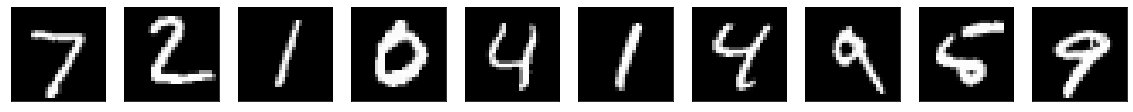

Dígitos reconstruídos utilizando Autoencoder: 


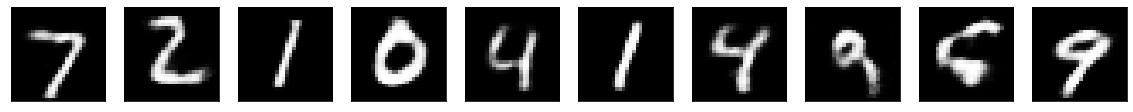

Dígitos reconstruídos utilizando PCA, com 100 componentes: 


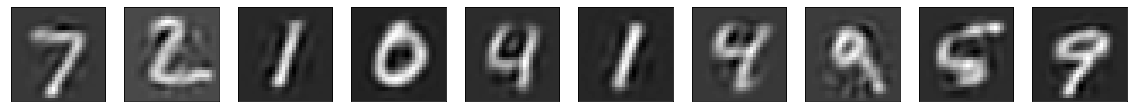

Dígitos reconstruídos utilizando PCA, com 200 componentes: 


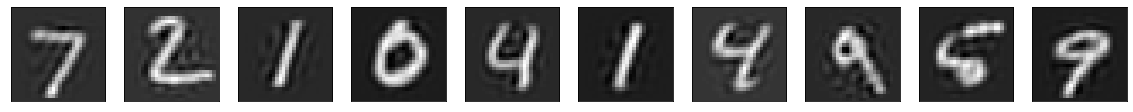

In [55]:
print("Dígitos originais: ")
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Dígitos reconstruídos utilizando Autoencoder: ")
plt.figure(figsize=(20, 4))
for i in range(n):
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Dígitos reconstruídos utilizando PCA, com 100 componentes: ")
plt.figure(figsize=(20, 4))
for i in range(n):
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(inv_sc_test_100[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Dígitos reconstruídos utilizando PCA, com 200 componentes: ")
plt.figure(figsize=(20, 4))
for i in range(n):
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(inv_sc_test_200[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Note que a utilização do Autoencoder (Teste 2) resultou em representações mais nítidas do que aquelas obtidas utilizando PCA, mesmo ao se adotar um número de componentes igual a 200.

***
## Referências

[1] Asha, Goyal. Autoencoders in Keras. Disponível em: <https://towardsdatascience.com/autoencoders-in-keras-c1f57b9a2fd7>. Acesso em 20 Dez. 2019.

[2] Milewski, Piotr. PCA decomposition and Keras neural network. Disponível em: <https://www.kaggle.com/pmmilewski/pca-decomposition-and-keras-neural-network>. Acesso em 20 Dez. 2019.